In [1]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
#from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
# Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine
from meshGen import mesh2DLaminates

import numpy as np


rotated = True
rotate_excitation = False
modelHalfAir = True

moartaring=False

onlySmooth = False
onlyRough = False

# class myDraw:
#     scenes = {}
#     def __init__(self, *args, **kwargs):
#         if id(args[0]) not in myDraw.scenes.keys():
#             myDraw.scenes.update({id(args[0]):Draw(*args, **kwargs)})
#         else:
#             myDraw.scenes[id(args[0])].Draw()
#     def updateAll():
#         for s in myDraw.scenes.values():
#             s.Redraw()

In [2]:
mu0 = 4e-7*np.pi

muAir = 1 * mu0
muFe = 10 * mu0

sigmaFe = 2e6

omega = 50 * 2*np.pi




order0 = 2

In [3]:
D = 0.04
d = 0.02

ff = 0.7


numSheets = 5

maxh_edges = d/numSheets*1/2 * 0.1


if onlySmooth:
    rotated = False

if onlyRough:
    rotated = True




## 4. All together with Eddy currents
### 4.1. Reference Solution 

In [4]:
import importlib

import meshGen as mg
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=[maxh_edges, maxh_edges], fullProblemX=True, onlySmooth = onlySmooth, onlyRough = onlyRough, rotated=rotated, modelHalfAir=modelHalfAir, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))

print(cMeshRef.dFe)
print("penetration depth = ", sqrt(2/(muFe*omega*sigmaFe)))


maxh_edges [0.0002, 0.0002]
Boundaries {'iright', 'right', 'bottom', 'default', 'ileft', 'ibottom', 'itop', 'top', 'left'}
Materials {'insulation', 'outer', 'inner'}
0.0028
penetration depth =  0.015915494309189534


In [5]:
Draw(meshRef)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [6]:
mu = meshRef.MaterialCF({"inner":muFe, "outer":muAir, "insulation":muAir, "gap":muAir, "multiscale":muFe})
def calcRef():
    fesPhi = H1(meshRef, order=order0, dirichlet="top|bottom" if rotate_excitation else "left|right" , complex=True)
    fesT = HCurl(meshRef, order=order0, dirichlet="itop|ibottom|ileft|iright", complex=True, definedon=meshRef.Materials("inner"))
    fes = FESpace([fesPhi, fesT])

    trials, tests = fes.TnT()
    sol = GridFunction(fes)

    a = BilinearForm(fes, symmetric=True)
    f = LinearForm(fes)

    a += 1j * omega * mu * (trials[1]-grad(trials[0])) * (tests[1]-grad(tests[0])) * dx
    a += 1/sigmaFe * curl(trials[1]) * curl(tests[1]) * dx("inner")
    a += 1e-1 * trials[0] * tests[0] * dx("inner")


    prec = Preconditioner(a, "direct")

    Phi = sol.components[0]
    T = sol.components[1]

    Phi.Set((1 * y/Norm(y)) if rotate_excitation else (1 * x/Norm(x)), BND)
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=10)
    
    
    energy =  Integrate( InnerProduct(mu * grad(Phi), grad(Phi)), meshRef, definedon=meshRef.Materials("inner|insulation")).real
    eddyLosses =  Integrate( InnerProduct(1/sigmaFe * curl(T), curl(T)), meshRef, definedon=meshRef.Materials("inner")).real
    
    return sol, energy, eddyLosses

sol_ref, energy_ref, eddyLosses_ref = calcRef()

Phi = sol_ref.components[0]
T = sol_ref.components[1]
H_ref = T-grad(Phi)
J_ref = curl(T)
B_ref = mu  * H_ref


CG iteration 1, residual = 0.08344435650050953     
CG iteration 2, residual = 1.6033325892292087e-09     
CG iteration 3, residual = 1.6116124600974712e-13     


In [7]:


print(f"energy:\t{energy_ref}")
print(f"eddy current losses:\t{eddyLosses_ref}")
Draw(J_ref.imag, meshRef, settings={"Objects":{"Wireframe":False}})




energy:	0.0005638553234071792
eddy current losses:	1.4076988804146208e-06


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [8]:
Draw( H_ref[0].real, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
Draw( H_ref[1].real, meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [9]:
Draw(B_ref.real[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
Draw(B_ref.real[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

### 4.2 Multiscale 

In [10]:
import cempy as cp
mg = importlib.reload(mg)
mesh2DLaminates = mg.mesh2DLaminates
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, onlySmooth=onlySmooth, 
        onlyRough=onlyRough, domainNameHalfAir="multiscale", maxh_edges= (maxh_edges, maxh_edges*5), rotated=rotated, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh
print(meshMS.GetMaterials())



maxh_edges (0.0002, 0.001)
('outer', 'outer', 'multiscale', 'gap', 'gap')


In [11]:
Draw(CF([1, 2, 3, 4, 5, 6]), meshMS)
from myPackage import drawBndAll

# drawBndAll(meshMS, drawFunc=Draw, block=False)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

In [12]:
import importlib
import MS_helper_functions as ms
ms = importlib.reload(ms)
cl_Phi = ms.cl_Phi

getIntegrand4BFI = ms.getIntegrand4BFI
cl_gradgradMS = ms.cl_gradgradMS
cl_curlcurlMS = ms.cl_curlcurlMS
pyLobatto = ms.pyLobatto
pydxLobatto = ms.pydxLobatto
getPhiPhiValue = ms.getPhiPhiValue
pyPhiFunction = ms.pyPhiFunction
pyPhiZero = ms.pyPhiZero
pyPhiConst = ms.pyPhiConst


cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshMS.dFe
cl_Phi.d0 = cMeshMS.d0
cl_Phi.mesh = meshMS

cl_Phi.modelHalfAir = True
cl_Phi.orientation = 1 if rotated else 0

if False:
    import cempy as cp
    importlib.reload(cp)
    
    
    cl_Phi.phiFunction = cp.phiFunctions.Lobatto
    cl_Phi.dzPhiFunction = cp.phiFunctions.dxLobatto
else:
    cl_Phi.phiFunction = pyLobatto
    cl_Phi.dzPhiFunction = pydxLobatto



Eddy currents
\begin{align*}
\mathbf{J} &= \nabla\times\mathbf{H} \\ 
 &= \nabla\times\Big(\sum_i\big(\nabla(\phi_i u_i)\big) + \sum_j \phi_jT_j\Big)\\
 &= \nabla\times\Big(\sum_i \phi_iT_i\Big)
\end{align*}


\begin{align*}
    \mathbf{J} = \nabla\times(\phi_i\mathbf{T}_i) &= \phi_i\nabla\times\mathbf{T}_i + \nabla\phi_i\times\mathbf{T}_i\\
    &=\phi_i\begin{pmatrix}\partial_y T_z-\partial_z T_y\\\partial_z T_x-\partial_x T_z \\ \partial_x T_y-\partial_y T_x\end{pmatrix} + \begin{pmatrix}\partial_x \phi_i\\\partial_y \phi_i \\ \partial_z \phi_i\end{pmatrix} \times \begin{pmatrix} T_x\\ T_y \\  T_z\end{pmatrix}\\
    &= \phi_i\begin{pmatrix}\partial_y T_z-\partial_z T_y\\\partial_z T_x-\partial_x T_z \\ \partial_x T_y-\partial_y T_x\end{pmatrix} + 
    \begin{pmatrix}\partial_y\phi_i T_z - \partial_z\phi_iT_y\\\partial_z\phi_i T_x - \partial_x\phi_iT_z \\\partial_x\phi_i T_y - \partial_y\phi_iT_x \end{pmatrix}
\end{align*}

for $\mathbf{T} = T_x\mathbf{e}_x + T_y\mathbf{e}_y $ and $\phi_i(\mathbf{x}) = \phi_i(x)$
$\rightarrow \mathbf{J} = J\mathbf{e}_z$ 

\begin{align*}
J &= \phi_i ( \partial_x T_y - \partial_y T_x) + \partial_x\phi_i T_y \\
&= \phi_i \textup{curl}_{\textup{2D}}(\mathbf{T}) + \partial_x\phi_i T_y 
\end{align*}

In [47]:
force_full_Phi = True


smoothB_fun_Fe = lambda x: 1e3 * muFe/muAir * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothB_fun_0 = lambda x: 1e3 * (-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)



smoothH_fun_Fe = lambda x: 1e3 * (x**2/cl_Phi.dFe * 1 - (cl_Phi.dFe/4 * 1))
smoothH_fun_0 = lambda x: 1e3*(-(x - (cl_Phi.d0/2+cl_Phi.dFe/2))**2/ cl_Phi.d0 * 1 + cl_Phi.d0/4 * 1)

smoothBPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothBPhi2", order="smB2", modelHalfAir=False)

smoothHPhi2 = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothH_fun_Fe, smoothH_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothHPhi2", order="smH2", modelHalfAir=False)

smoothPhi2_Fe = pyPhiFunction(cl_Phi.getZStart(), cl_Phi.getD(), 
    [smoothB_fun_Fe, smoothB_fun_0], numSheets, ff, cl_Phi.orientation, name = "smoothPhi2", order="sm2", modelHalfAir=False, inAir=False)
    
def calcMultiscale(useGradients=True, drawPhis=True):
    domains = "multiscale|gap"
    if onlySmooth:
        domains = "multiscale"

    roughbnd = "left|right" if rotated else "top|bottom"
    roughbnd_inner = "ileft|iright" if rotated else "itop|ibottom"
    smoothbnd = "itop|ibottom" if rotated else "ileft|iright"

    if onlySmooth:
        roughbnd = ""

    print("moartaring", moartaring)
    print("modelHalfAir", modelHalfAir)
    print("domains", domains)
    print("roughbnd", roughbnd)
    print("smoothbnd", smoothbnd)

    # microshape functions

    
    """
    only roguh

    orderPhi = [
        # do not remove!
        cl_Phi([pyPhiConst(), pyPhiZero()], fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=False), 

        cl_Phi(1, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=True, modelHalfAir=True), 
     
        cl_Phi([smoothBPhi2, smoothBPhi2.getDiff()], fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),
        cl_Phi(2, fes_order=1, material=domains, dirichlet=roughbnd, inIron=False, modelHalfAir=False), 
    ]

    orderT = [
        # cl_Phi([pyPhiConst(val = 1, inAir=False), pyPhiZero()], fes_order=2, material="multiscale", dirichlet=roughbnd_inner+ "|" + smoothbnd, inAir=False), 

        # cl_Phi(1, fes_order=1, material="multiscale", dirichlet=roughbnd_inner, inAir=False, modelHalfAir=False),  
        cl_Phi(2, fes_order=2, material="multiscale", dirichlet=roughbnd_inner, inAir=False, modelHalfAir=False), 
    ]
    """
    orderPhi = [
            # do not remove!
            cl_Phi([pyPhiConst(), pyPhiZero()], fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=False), 

            cl_Phi(1, fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, useAbsolutes=True, modelHalfAir=True), 
# 
            # cl_Phi([smoothBPhi2, smoothBPhi2.getDiff()], fes_order=1, material=domains, dirichlet=roughbnd, useGradients=True, modelHalfAir=False),
            cl_Phi(2, fes_order=1, material=domains, dirichlet=roughbnd+ "|" + smoothbnd, inAir=False, modelHalfAir=False), 
            cl_Phi(2, fes_order=1, material=domains, dirichlet=roughbnd+ "|" + smoothbnd, inIron=False, modelHalfAir=False), 
        ]

    orderT = [
        # cl_Phi([pyPhiConst(val = 1, inAir=False), pyPhiZero()], fes_order=2, material="multiscale", dirichlet=roughbnd_inner+ "|" + smoothbnd, inAir=False, nograds=False), 
        # cl_Phi(1, fes_order=2, material="multiscale", dirichlet=roughbnd_inner, inAir=False, modelHalfAir=True, nograds=True),  
        cl_Phi(2, fes_order=2, material="multiscale", dirichlet=roughbnd_inner , inAir=False, modelHalfAir=False, nograds=True), 
    ]

    if not moartaring:
        orderPhi = orderPhi[1:]

    if drawPhis:
        # cl_Phi.plotEvaluated(orderPhi, nFig=1)
        cl_Phi.plotEvaluated(orderT, nFig=1)
        cl_Phi.plotDirectEvaluated(orderT, nFig=1)

    VSpace = []
    # # u0 
    domains_outer = "outer"
    if not moartaring:
        domains_outer += "|" + domains
    VSpace.append(H1(meshMS, order=order0+1, dirichlet="top|bottom" if rotate_excitation else "left|right", definedon=meshMS.Materials(domains_outer), complex=True)) 
        
    # ui * phi i
    for phi_i in orderPhi: 
        VSpace.append(H1(meshMS, order=phi_i.fes_oder+1, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet, complex=True))

    for phi_i in orderT: 
        VSpace.append(HCurl(meshMS, order=phi_i.fes_oder, definedon=meshMS.Materials(phi_i.material), dirichlet=phi_i.dirichlet, complex=True, nograds=phi_i.nograds))

    VSpace = FESpace(VSpace)


    # multiscale container
    ansatz = ""
    sol = GridFunction(VSpace, "sol")
       

    gradgradMS = cl_gradgradMS(orderPhi, sol, addPhi0Outer=True, secondOrder=False)
    curlcurlMS = cl_curlcurlMS(orderT, sol, eddy_inplane=False, istart = len(gradgradMS.orderPhi) + 1)


    gradgradMS.addCurlCurlMS(curlcurlMS)


    if moartaring:
        slice_inner = slice(1, len(gradgradMS.gradu_pack))
    else:
        slice_inner = slice(0, len(gradgradMS.gradu_pack))


    a = BilinearForm(VSpace, symmetric=True)
    f = LinearForm(VSpace)

    a += 1j * omega * muAir  * grad(gradgradMS.trials[0]) * grad(gradgradMS.tests[0]) * dx("outer")
    # a += 1j * 1e-1  * gradgradMS.trials[0] * gradgradMS.tests[0] * dx("multiscale")
    a += 1j * omega * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack[slice_inner], gradgradMS.gradv_pack[slice_inner], muAir, muAir, force_full_Phi=force_full_Phi) * dx("gap")
    a += 1j * omega * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_pack[slice_inner], gradgradMS.gradv_pack[slice_inner], muFe, muAir, force_full_Phi=force_full_Phi) * dx("multiscale")

    a += curlcurlMS.getIntegrand4BFI(curlcurlMS.curlu_pack, curlcurlMS.curlv_pack, 1/sigmaFe, 0, force_full_Phi=force_full_Phi) * dx("multiscale")
    

    






    # couple u
    if False:
        alpha = 3.5
        h = specialcf.mesh_size

        u_start = 1 if moartaring else 0
        # alpha = 1e6
        d_coupling = -d/2 if modelHalfAir else -d/2 + cl_Phi.d0/2


        # absolutes
        u_range = range(u_start, len(gradgradMS.u_pack))
        # u_range = list(range(2, len(gradgradMS.u)))
        # u_range = [0] + u_range

        # u_range = [u_start]
        um_bottom = sum(gradgradMS.u_pack[i][0] * gradgradMS.u_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)
        vm_bottom = sum(gradgradMS.v_pack[i][0] * gradgradMS.v_pack[i][1].DirectEvaluate(-d_coupling) for i in u_range)

        um_top = sum(gradgradMS.u_pack[i][0] * gradgradMS.u_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)
        vm_top = sum(gradgradMS.v_pack[i][0] * gradgradMS.v_pack[i][1].DirectEvaluate(d_coupling) for i in u_range)

        jump_u_top = gradgradMS.u_pack[0][0] - um_top
        jump_u_bottom = gradgradMS.u_pack[0][0] - um_bottom

        jump_v_top = gradgradMS.v_pack[0][0] - vm_top
        jump_v_bottom = gradgradMS.v_pack[0][0] - vm_bottom
        
        #[u][v]
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[u_start:], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[:1],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        # a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.u_pack[:1], gradgradMS.v_pack[u_start:],  1, 1, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        a += alpha*order0**2/h  * (jump_u_top)  * (jump_v_top)  *ds("itop")
        a += alpha*order0**2/h  * (jump_u_bottom)  * (jump_v_bottom)  *ds("ibottom")
        



    # couple fluxes
    if False:
        # [dn u] [ dn v]

        alpha = 2000
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[u_start:],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[u_start:], gradgradMS.gradv_trace_n_pack[:1],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[:1],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)
        a += -alpha*order0**2/h  * gradgradMS.getIntegrand4BFI(gradgradMS.gradu_trace_n_pack[:1], gradgradMS.gradv_trace_n_pack[u_start:],  muFe, muAir, force_full_Phi=force_full_Phi)  *ds(smoothbnd)

        # alpha = 2
        # a += alpha*order0**2/h  * (jump_Bu_top)  * (jump_Bv_top)  *ds("itop")
        # a += alpha*order0**2/h  * (jump_Bu_bottom)  * (jump_Bv_bottom)  *ds("ibottom")


    prec = Preconditioner(a,type="direct")  


    # dirichlet boundary values
    sol.components[0].Set((1 * y/Norm(y)) if rotate_excitation else (x/Norm(x)), BND)
    if moartaring:
        sol.components[1].Set((1 * y/Norm(y)) if rotate_excitation else (x/Norm(x)), BND)
    
    solvers.BVP(bf = a, lf= f, pre=prec, gf=sol, maxsteps=30, tol = 1e-20)


    H_MS = sum(gradgradMS.gradsol_comp)
    J_MS = sum(curlcurlMS.curlsol_comp)



    energy =  Integrate(gradgradMS.getIntegrand4BFI(gradgradMS.gradsol_pack, gradgradMS.gradsol_pack, muFe, muAir), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))

    losses =  Integrate(curlcurlMS.getIntegrand4BFI(curlcurlMS.curlsol_pack, curlcurlMS.curlsol_pack, 1/sigmaFe, 0), meshMS, 
                                                    definedon=meshMS.Materials("multiscale"))
    
    
    print("a norm", a.mat.AsVector().Norm())

    print("ansatz", gradgradMS.ansatz)
    return sol, energy, losses, gradgradMS, curlcurlMS, H_MS, J_MS

    






moartaring False
modelHalfAir True
domains multiscale|gap
roughbnd left|right
smoothbnd itop|ibottom


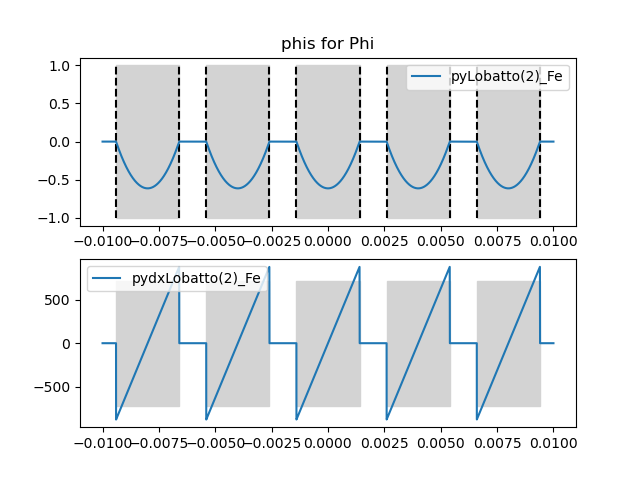

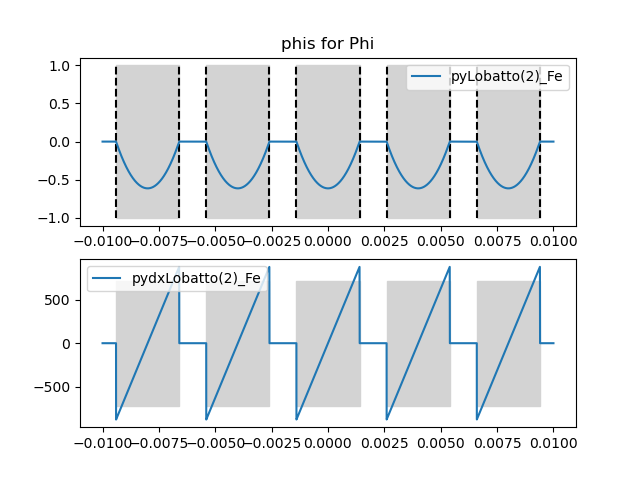

CG iteration 1, residual = 0.16240604392836125     
CG iteration 2, residual = 2.978676528086339e-15     
CG iteration 3, residual = 1.4459888594840948e-27     
a norm 542.5219896681297
ansatz -grad(u0_outer) - grad(u1 * pyLobatto(1)) - grad(u2 * pyLobatto(2)_Fe) - grad(u3 * pyLobatto(2)_ins) + T4 * pyLobatto(2)_Fe
energy_ref, energy_MS 0.0005638553234071792 (9.274974545928464e-07-2.7836956911157776e-09j)
eddy_ref, eddy_MS 1.4076988804146208e-06 (-1.6085353563623167e-06+5.855664614528487e-08j)


In [48]:

if "curlcurlMS" in locals():
    del curlcurlMS
sol_MS, energy_MS, eddyLosses_MS, gradgradMS, curlcurlMS, H_MS, J_MS = calcMultiscale(False, drawPhis=True)

#H_MS.Compile()
# print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
# print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")

# print(Integrate(Norm(sum(sol_comp_MS) - sol_ref), meshRef))


u_MS = sum(gradgradMS.sol_comp[:len(gradgradMS.orderPhi)])

print("energy_ref, energy_MS", energy_ref, energy_MS)
print("eddy_ref, eddy_MS", eddyLosses_ref, eddyLosses_MS)

In [49]:
from ngsolve.webgui import Draw

print(curlcurlMS.orderPhi[0].dirichlet)
print(set(meshMS.GetBoundaries()))
from myPackage import drawBnd

# drawBnd(meshMS, "ibottom", drawFunc=Draw)
Draw(sum(curlcurlMS.curlsol_comp).imag, meshRef, settings = {"Objects":{"Wireframe":False}}, min = -200, max=200)



ileft|iright
{'right', 'iright', 'bottom', 'ileft', 'ibottom', 'itop', 'top', 'left'}


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [16]:

curlcurlMS.printCouplingMatrix(sparsity=True);


                       0                1
--  -----------------  ---------------  -----------------
                       pyLobatto(2)_Fe  pydxLobatto(2)_Fe
0   pyLobatto(2)_Fe    x
1   pydxLobatto(2)_Fe                   x


In [17]:
#gradgradMS.generateCouplingMatrix(muFe, muAir, force_full_Phi=force_full_Phi)
gradgradMS.printCouplingMatrix(sparsity=True);
#assert gradgradMS.checkCouplingMatrxiSymmetric(1e-3) == True

                        0              1               2             3                  4                5                   6                 7
--  ------------------  -------------  --------------  ------------  -----------------  ---------------  ------------------  ----------------  ---------------
                        pyPhiConstant  pydxLobatto(1)  pyLobatto(1)  pydxLobatto(2)_Fe  pyLobatto(2)_Fe  pydxLobatto(2)_ins  pyLobatto(2)_ins  pyLobatto(2)_Fe
0   pyPhiConstant       x              x                                                x                                    x                 x
1   pydxLobatto(1)      x              x                                                x                                    x                 x
2   pyLobatto(1)                                       x             x                                   x
3   pydxLobatto(2)_Fe                                  x             x
4   pyLobatto(2)_Fe     x              x                             

In [18]:
curlcurlMS.generateCouplingMatrix(1/sigmaFe, 0, force_full_Phi=force_full_Phi)
curlcurlMS.printCouplingMatrix(sparsity=1);
# assert curlcurlMS.checkCouplingMatrxiSymmetric(1e-3) == True



                       0                1
--  -----------------  ---------------  -----------------
                       pyLobatto(2)_Fe  pydxLobatto(2)_Fe
0   pyLobatto(2)_Fe    x
1   pydxLobatto(2)_Fe                   x


In [19]:
print(f"energy MS :\t{energy_MS}, energy ref \t{energy_ref}")
print(f"eddyLosses MS :\t{eddyLosses_MS}, eddyLosses ref \t{eddyLosses_ref}")
print(meshMS.GetBoundaries())
#Draw(u_MS, meshRef, settings={"Objects":{"Wireframe":True}, "deformation": 0.01}, deformation=False)
# Draw( Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max = 200)
# Draw( lam * Norm(H_MS), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=400)

energy MS :	(9.274974545928433e-07-2.7836956911157255e-09j), energy ref 	0.0005638553234071792
eddyLosses MS :	(-1.6085353563622905e-06+5.855664614529016e-08j), eddyLosses ref 	1.4076988804146208e-06
('bottom', 'left', 'ibottom', 'ibottom', 'ibottom', 'right', 'itop', 'itop', 'itop', 'left', 'top', 'right', 'iright', 'ileft', 'right', 'left')


### 1.3 Comparison 

In [20]:

start = -D/2*1.01
end = -D/2*0.9

start = -d/2
end = d/2


plt.figure(2)
start = -d/2
end = d/2

pnt1 = [-d/2*0.99, start, 0] if rotated else [start, -d/2*0.99, 0]
pnt2 = [-d/2*0.99, end, 0] if rotated else [end, -d/2*0.99, 0]




In [21]:
from ngsolve.webgui import Draw
scene1 = Draw(IfPos(x if rotated else y, J_ref.imag, J_MS.imag) ,meshRef, settings={"Objects":{"Wireframe":False}}, min = -200, max=200)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [22]:

Draw = lambda *args, **kwargs : None

In [23]:
curlcurlMS.curlsol_comp

In [24]:
print([gradgradMS.gradsol_comp[i].is_complex for i in range(len(curlcurlMS.curlsol_comp))])
print([curlcurlMS.curlsol_comp[i].is_complex for i in range(len(curlcurlMS.curlsol_comp))])

[True, True]
[True, True]


In [25]:
scene1 = Draw( curlcurlMS.curlsol_comp[0].imag ,meshRef, settings={"Objects":{"Wireframe":False}})

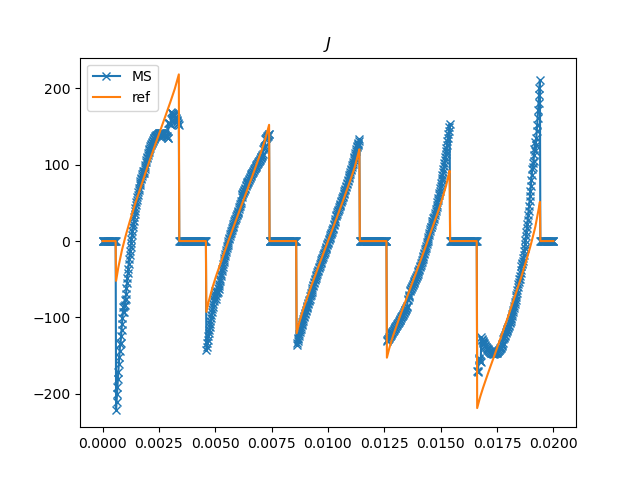

In [26]:
start = -d/2
end = d/2


i = 0
plt.figure(3)
evalOnLine(J_MS.imag , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(curlcurlMS.curlsol_comp[i].imag , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$J$");
evalOnLine(J_ref.imag , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$J$");



plt.legend()
plt.show()

In [27]:
i = 1
print(len(curlcurlMS.curlsol_pack))
Draw(curlcurlMS.curlsol_pack[i][0].imag * curlcurlMS.curlsol_pack[i][1], meshRef, max=300, min = -300, settings={"Objects":{"Wireframe":False}})

Integrate(curlcurlMS.curlsol_pack[i][0].imag, meshRef, definedon=meshRef.Materials("inner"))
Integrate(J_MS, meshRef, definedon=meshRef.Materials("inner"))

2


(1.458542452749423e-07+8.648563347086796e-08j)

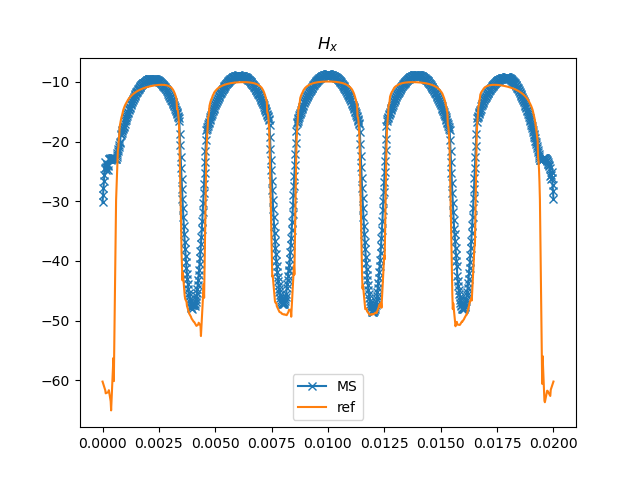

In [28]:
start = -d/2
end = d/2

plt.figure(3)
evalOnLine(H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
evalOnLine(H_ref[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_x$");



plt.legend()
plt.show()

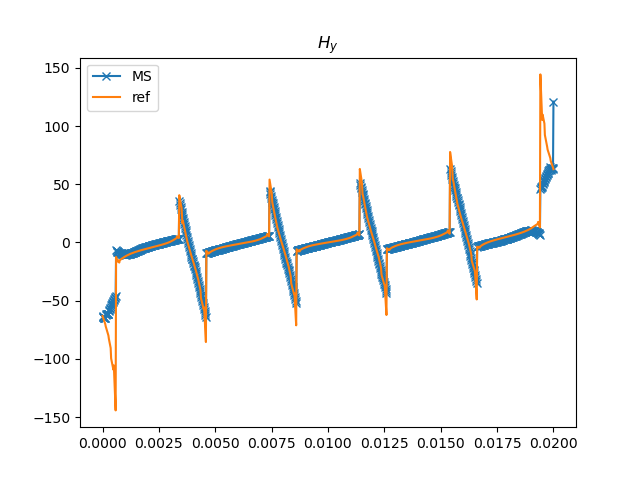

In [29]:
start = -d/2
end = d/2


plt.figure(4)

evalOnLine(H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# [evalOnLine((H_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(H_comp))];

evalOnLine(H_ref[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$H_y$");
plt.legend()
plt.show()

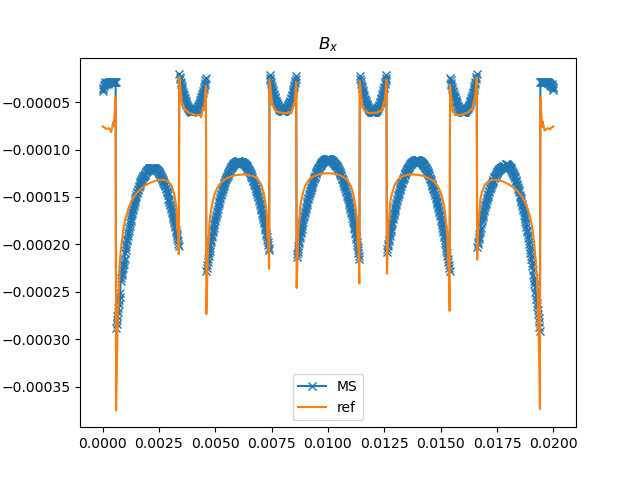

In [30]:
start = -d/2
end = d/2


plt.figure(5)
evalOnLine(mu * H_MS[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);
# evalOnLine(lam * (H_comp[0])[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS", show=False, N=1000);
evalOnLine(mu * H_ref[0] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_x$");

plt.legend()
plt.show()

pyPhiConstant
pydxLobatto(1)
pyLobatto(1)
pydxLobatto(2)_Fe
pyLobatto(2)_Fe
pydxLobatto(2)_ins
pyLobatto(2)_ins
pyLobatto(2)_Fe


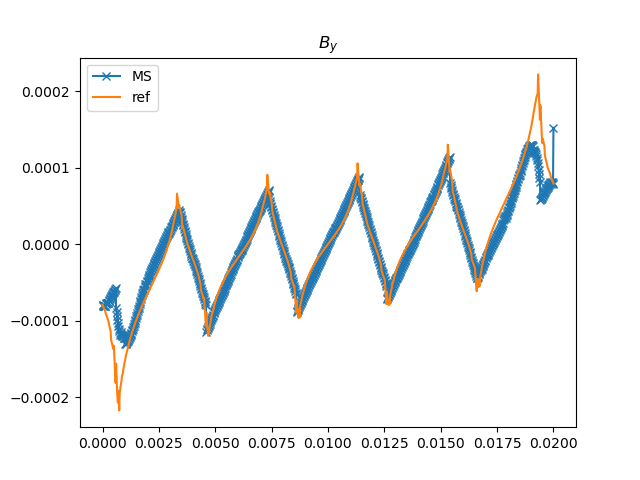

In [31]:
start = -d/2
end = d/2

[print(o[1].name) for o in gradgradMS.gradsol_pack]

plt.figure(6)
H_MS = sum(gradgradMS.gradsol_comp) 
evalOnLine(mu * H_MS[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=True, label="MS", show=False, N=1000);

# [evalOnLine(mu * (gradgradMS.gradsol_comp[i])[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="x", clear=False, label="MS_" + gradgradMS.gradsol_pack[i][1].name, show=False, N=1000) for i in range(len(gradgradMS.gradsol_comp))];

evalOnLine(mu * H_ref[1] , meshRef, pnt1, pnt2, plot=True, ls='-', marker="", show=False, clear=False, label="ref", N = 1000, title=r"$B_y$");

plt.legend()
plt.show()

### Drawings

In [46]:
from ngsolve.webgui import Draw

print(Integrate(InnerProduct(J_MS* 1/sigmaFe, J_MS), meshRef))
print(Integrate(InnerProduct(J_ref * 1/sigmaFe, J_ref), meshRef))

InnerProduct(1/sigmaFe * curl(T), curl(T))

(1.3925402422596326e-06-9.927098197880472e-27j)
(1.4076988804146208e-06+2.238380398792397e-27j)


In [36]:
from ngsolve.webgui import Draw
scene1 = Draw(IfPos(x if rotated else y, J_ref.imag, J_MS.imag) ,meshRef, settings={"Objects":{"Wireframe":False}}, min = -200, max=200)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

In [37]:
print(f"energy:\t{energy_MS}", energy_ref)
print(f"losses:\t{eddyLosses_MS}", eddyLosses_ref)
Draw(IfPos(y, sol_ref.components[0], sum(gradgradMS.sol_comp)), meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})


energy:	(9.274974545928433e-07-2.7836956911157255e-09j) 0.0005638553234071792
losses:	(-1.6085353563622905e-06+5.855664614529016e-08j) 1.4076988804146208e-06


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [34]:
Draw(IfPos(y, H_ref, H_MS)[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)
Draw(IfPos(y, H_ref, H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False}, max=50, min = -50)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [35]:
Draw(mu * IfPos(y, H_ref, H_MS)[0], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
Draw(mu * IfPos(y, H_ref, H_MS )[1], meshRef, settings={"Objects":{"Wireframe":False}, "deformation": False})
# lamMS = IfPos(cl_Phi(0, 0, inIron=False, material="multiscale").phi, lambda1, lambda2)

# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[0], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -200, max=200)
# Draw(lamMS * IfPos(y, -grad(sol_ref), H_MS)[1], meshMS, settings={"Objects":{"Wireframe":False}, "deformation": False},min = -20, max=20)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fal…

BaseWebGuiScene

In [ ]:
# print("Norm soll diff", Integrate((sum(sol_comp_MS) - sol_ref)* (sum(sol_comp_MS) - sol_ref)/( (sol_ref)**2) , meshRef)*100,  "%")
print("diff energy", energy_MS, energy_ref, energy_MS - energy_ref, (energy_MS - energy_ref)/energy_ref * 100, "%")
print("diff eddylosses", eddyLosses_MS, eddyLosses_ref, eddyLosses_MS - eddyLosses_ref, (eddyLosses_MS - eddyLosses_ref)/eddyLosses_ref * 100, "%")

print((1.3888 - 1.407)/1.407*100)

diff energy (9.096593437557524e-07-2.6286645332635274e-09j) 0.0005638553234071792 (-0.0005629456640634235-2.6286645332635274e-09j) (-99.83867149852217-0.0004661948595926049j) %
diff eddylosses (-1.4622437971256187e-06+5.4208889463906625e-08j) 1.4076988804146208e-06 (-2.8699426775402393e-06+5.4208889463906625e-08j) (-203.87475741224802+3.8508867356589818j) %
-1.2935323383084574
